# Climate-Economic Correlation Analysis

This notebook analyzes correlations between climate variables (from ERA5-Land reanalysis data) and macroeconomic indicators across different countries.

## Objective
- Process hourly ERA5-Land climate data (temperature, precipitation, evaporation)
- Align climate variables with quarterly economic data by country
- Compute spatial averages over country regions
- Analyze correlations between climate anomalies and economic performance

## Data Sources
- **Climate Data**: ERA5-Land hourly reanalysis (1980-2024)
- **Economic Data**: Quarterly macroeconomic indicators by country (`df_country_data_climate.xlsx`)

## Setup and Configuration

In [4]:
import os
import numpy as np
import pandas as pd # type: ignore
import xarray as xr # type: ignore
from pathlib import Path
import pickle
from tqdm import tqdm
import multiprocessing
import dask
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar

# Get number of CPU cores
n_cores = multiprocessing.cpu_count()
print(f"Detected {n_cores} CPU cores")

# put this on your fastest SSD/NVMe with plenty of free space
SPILL_DIR = r"C:\dask-spill"
os.makedirs(SPILL_DIR, exist_ok=True)

dask.config.set({
    "distributed.worker.local-directory": SPILL_DIR,
    "distributed.worker.memory.target": 0.70,    # start spilling earlier
    "distributed.worker.memory.spill": 0.80,
    "distributed.worker.memory.pause": 0.88,
    "distributed.worker.memory.terminate": 0.98,
    "distributed.comm.compression": "auto",      # or None if codec issues reappear
})

cluster = LocalCluster(
    n_workers=1,
    threads_per_worker=12,       # 14900K has plenty; adjust if you want
    processes=False,             # threads-only on Windows
    memory_limit="48GB",         # leave headroom for OS/Jupyter
)
client = Client(cluster)

print("\nDask cluster ready for parallel processing!")

# HDF5 locking issues (Rockfish/HPC): set once per process if needed
# os.environ.setdefault("HDF5_USE_FILE_LOCKING", "FALSE")
# os.environ["NETCDF_HDF5_FILE_LOCKING"] = "FALSE"
#xr.set_options(display_style="text") # Display xarray in plain text

# --path--
# era5land_quarterly_data = "/vast/bzaitch1/trp_climate_model_data/era5land_1970_2024_qtrmean" # Location on Rockfish
# era5land_quarterly_data_directory = Path("/Users/kris/Local Job Backup/test set/") # Location on local machine
#output_directory  = "/vast/bzaitch1/trp_climate_model_data/out"
#os.makedirs(output_directory, exist_ok=True)
QUARTER_DIR = Path(rf"E:\backup\trp_climate_model_data\era5land_1970_2024_qtrmean")

# Hourly filename pattern:
# One file per month:    YYYY_MM.nc
PATTERN_PER_MONTH = "{y}_{m}.nc"   # for one file per month

cvar_aliases = {
    'tp' : 'total precipitation', 
    't2m' : '2 metre temperature',
    'e' : 'evaporation',
}

evar_aliases = {
    'y' : 'Log of real GDP', 
    'Dp' : 'Inflation rate (Based on CPI)',
    'eq' : 'Log of real equity prices',
    'ep' : 'Log of real exchange rate',
    'r' : 'Short-term interest rate',
    'lr' : 'Long-term interest rate',
}


Detected 32 CPU cores

Dask cluster ready for parallel processing!


## Climate Data Loading and Inspection

Load ERA5-Land data to understand structure and available variables (temperature, precipitation, evaporation).

In [14]:
test_data_set = QUARTER_DIR / '*.nc'
ds = xr.open_mfdataset(str(test_data_set), engine='netcdf4')
da = ds['tp']
ds.close()

DROP 'number' variable from files made with old pipeline


In [ ]:
# for year in tqdm(range(1980, 1991)):
#     for q in range(1, 5):
#         era5_quarterly_data = QUARTER_DIR / f'{year}_Q{q}_qmean.nc'
#         #obs_files.append(era5_quarterly_data)
#         ds = xr.open_dataset(str(era5_quarterly_data), engine='netcdf4')
#         if 'number' in ds.variables:  # Use .variables instead of .var()
#             print(f'\n "number" variable found in {year}_Q{q}; dropping...')
#             ds = ds.drop_vars('number')  # ASSIGN back to ds!
#             print(f'Saving to {str(QUARTER_DIR)}/correction/{year}_Q{q}_qmean.nc \n')
#             ds.to_netcdf(str(QUARTER_DIR / rf'correction') + f'/{year}_Q{q}_qmean.nc')
#         else:
#             print(f'No "number" variable in {year}_Q{q}')

### Data Preprocessing

Coordinate Transformations - Prepare the climate data for efficient processing by:
- Convert longitude from 0-360° to -180-180° range
- Ensure latitude is in ascending order
- Convert temperature from Kelvin to Celsius

In [15]:
# --- fix longitude from 0..360 to -180..180 and sort ---
if float(da.longitude.max()) > 180:
    lon_new = ((da.longitude + 180) % 360) - 180
    da = da.assign_coords(longitude=lon_new).sortby("longitude")

# --- make latitude ascending (optional but helpful for weights) ---
if da.latitude[0] > da.latitude[-1]:
    da = da.sortby("latitude")

# --- convert K -> °C ---
# if str(da.attrs.get("units", "")).lower() in ("k", "kelvin"):
#     da = da - 273.15
#     da.attrs["units"] = "degC"

da

<xarray.DataArray 'tp' (valid_time: 160, latitude: 1801, longitude: 3600)>
dask.array<getitem, shape=(160, 1801, 3600), dtype=float32, chunksize=(1, 1801, 3600), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * longitude   (longitude) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * valid_time  (valid_time) datetime64[ns] 1980-03-31 1980-06-30 ... 2019-12-31
Attributes: (12/33)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.0
    coordinates:                              number

## Detrending Functions
These functions remove seasonal cycles and linear trends from climate data to isolate anomalies:

- **Detrending**: Removes linear trends from time series
- **Seasonal Removal**: Subtracts monthly climatology to get anomalies

This is essential for correlation analysis as we want to compare climate anomalies with economic deviations.

In [16]:
def detrend_dim(da, dim, deg=1):
    p = da.polyfit(dim=dim, deg=deg) #least squares polynomial fit
    fit = xr.polyval(da[dim], p.polyfit_coefficients) # gives line of best fit
    return da - fit #subtracts linear fit from data

def det_data(ds, subset=None):
    """
    Detrend climate data by removing seasonal cycle and linear trend.
    
    Parameters:
    -----------
    ds : xr.DataArray
        Input climate variable
    subset : dict, optional
        Dictionary to subset data for faster testing, e.g.:
        {'lat': slice(-20, 20), 'lon': slice(-80, -40), 'time': slice('1980', '1990')}
    
    Returns:
    --------
    xr.DataArray : Detrended anomalies with preserved attributes
    """
    # Save original metadata
    original_attrs = ds.attrs.copy()
    original_name = ds.name
    
    # Optional subsetting for faster testing
    if subset is not None:
        ds = ds.sel(**subset)
        print(f"Subset to: {ds.sizes}")
    
    # Calculate seasonal climatology for each quarter (Q1, Q2, Q3, Q4)
    climatology = ds.groupby("valid_time.quarter").mean(dim='valid_time')
    
    # Remove seasonal cycle to get anomalies
    anomalies = ds.groupby("valid_time.quarter") - climatology
    
    # Detrend the anomalies (remove linear trend)
    detrend = detrend_dim(anomalies, 'valid_time')
    
    # Restore metadata
    detrend.attrs = original_attrs
    detrend.name = original_name
    
    return detrend

In [17]:
det_da = det_data(da)
# with open('./cache/det_da_test.pkl', 'wb') as f:
#     pickle.dump(det_da.values, f)
# print("Saved detrended data to det_da_test.pkl")

# with open('./cache/det_da_test.pkl', 'rb') as f:
#     det_da = pickle.load(f)
det_da

<xarray.DataArray 'tp' (valid_time: 160, latitude: 1801, longitude: 3600)>
dask.array<sub, shape=(160, 1801, 3600), dtype=float64, chunksize=(1, 1801, 3600), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * longitude   (longitude) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * valid_time  (valid_time) datetime64[ns] 1980-03-31 1980-06-30 ... 2019-12-31
    quarter     (valid_time) int64 1 2 3 4 1 2 3 4 1 2 3 ... 3 4 1 2 3 4 1 2 3 4
Attributes: (12/33)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.0
    coordinates:                              number

### (Optional) Checking

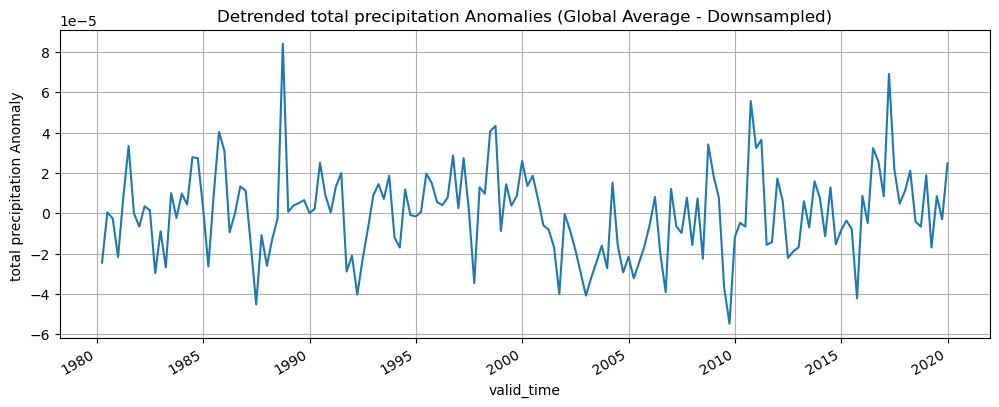

In [30]:
# Quick check: plot detrended anomalies (spatial average time series)
# Use subset for faster plotting
import matplotlib.pyplot as plt

# Downsample spatially for quick check (every 20th point)
det_da_sample = det_da.isel(latitude=slice(None, None, 20), longitude=slice(None, None, 20))

evar_label = cvar_aliases.get('tp')

# Compute and plot
det_da_sample.mean(dim=['latitude','longitude']).plot(figsize=(12, 4))
plt.title(f'Detrended {evar_label} Anomalies (Global Average - Downsampled)')
plt.ylabel(f'{evar_label} Anomaly ') #(°C)
plt.grid(True)
plt.show()

## Correlation with Econometrics

In [23]:
def correlate_with_econm(det_da, econ_var_series):
    """
    Correlate detrended climate data at every grid point with an economic time series.
    
    Parameters:
    -----------
    det_da : xr.DataArray
        Detrended climate variable (e.g., temperature anomalies) with dimensions (valid_time, latitude, longitude)
    econ_var_series : pd.Series
        Economic indicator time series with datetime index matching climate data times
    
    Returns:
    --------
    xr.DataArray : Correlation coefficients at each grid point (latitude, longitude)
    """
    
    # Find overlapping time period
    climate_times = pd.DatetimeIndex(det_da.valid_time.values)
    econ_times = econ_var_series.index
    
    # Get intersection of times
    common_times = climate_times.intersection(econ_times)
    
    if len(common_times) == 0:
        raise ValueError("No overlapping time periods between climate and economic data!")
    
    print(f"Found {len(common_times)} overlapping time periods")
    
    # Subset both datasets to common times
    det_da_subset = det_da.sel(valid_time=common_times)
    econ_subset = econ_var_series.loc[common_times]
    
    # Remove any NaN values from economic series
    valid_mask = econ_subset.notna()
    if not valid_mask.all():
        print(f"Removing {(~valid_mask).sum()} NaN values from economic series")
        det_da_subset = det_da_subset.sel(valid_time=valid_mask.values)
        econ_subset = econ_subset[valid_mask]
    
    # Convert to xarray DataArray
    econ_da = xr.DataArray(
        econ_subset.values,
        coords={'valid_time': det_da_subset.valid_time},
        dims=['valid_time']
    )
    
    # Use xarray's built-in correlation function
    correlation_map = xr.corr(det_da_subset, econ_da, dim='valid_time')
    
    return correlation_map

In [29]:
df = pd.ExcelFile("./df_country_data_climate.xlsx")
list_countries = df.sheet_names
#pd.read_excel(df)

# Example: Create correlation map between temperature anomalies and Argentina GDP
# Load Argentina economic data
econ_argentina = pd.read_excel(df, sheet_name='Argentina')

# Prepare economic time series (example with first numeric column)
# Set time index
# econ_argentina['time'] = pd.PeriodIndex(econ_argentina['Unnamed: 0'], freq='Q-DEC').to_timestamp(how='end')
# econ_argentina['time'] = econ_argentina['Unnamed: 0']#.to_timestamp(how='end')
econ_argentina = econ_argentina.set_index('Unnamed: 0')
econ_argentina = econ_argentina[3:]

# Pick an economic variable (e.g., 'gdp', 'cpi', etc. - adjust to your actual column name)
# List available columns first
print("Available economic variables:", econ_argentina.columns.tolist())

# Example: use first numeric column
econ_var_name = econ_argentina.select_dtypes(include=[np.number]).columns[0]
print(f"\nUsing variable: {econ_var_name}")

econ_series = econ_argentina[econ_var_name]

# Compute correlation map
#corr_map = correlate_with_econm(det_da, econ_series)
#corr_map
# with open('./cache/correlation_maps.pkl', 'wb') as f:
#     pickle.dump(corr_map.values, f)
# print("Saved correlation maps to correlation_maps.pkl")

#corr_map = corr_map.compute()

#Plot the correlation map
# corr_map.plot(figsize=(12, 6), cmap='RdBu_r', vmin=-1, vmax=1, cbar_kwargs={'label': 'Correlation'})
# plt.title(f'Correlation: Temperature Anomalies vs {econ_var_name} (Argentina)')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

Available economic variables: ['y', 'Dp', 'eq', 'ep', 'r', 'ys', 'Dps', 'eqs', 'rs', 'lrs', 'ensos']

Using variable: y


In [ ]:
# DEBUG: Check time alignment and data quality
print("Climate data time range:")
print(f"  Start: {det_da.valid_time.values[0]}")
print(f"  End: {det_da.valid_time.values[-1]}")
print(f"  Length: {len(det_da.valid_time)}")

print("\nEconomic data time range:")
print(f"  Start: {econ_argentina.index[0]}")
print(f"  End: {econ_argentina.index[-1]}")
print(f"  Length: {len(econ_argentina)}")

print(f"\nEconomic variable '{econ_var_name}' stats:")
print(f"  NaN count: {econ_series.isna().sum()}")
print(f"  Valid values: {econ_series.notna().sum()}")
print(f"  Mean: {econ_series.mean():.2f}")
print(f"  Std: {econ_series.std():.2f}")

# Check alignment
econ_aligned = econ_series.reindex(det_da.valid_time.values)
print(f"\nAfter alignment:")
print(f"  NaN count: {econ_aligned.isna().sum()}")
print(f"  Valid values: {econ_aligned.notna().sum()}")

# Check overlap
print("\nFirst 5 times in each:")
print("Climate:", det_da.valid_time.values[:5])
print("Economic:", econ_argentina.index[:5].values)

In [ ]:
#Plot the correlation map
# import matplotlib.pyplot as plt
# corr_map.plot(figsize=(12, 6), cmap='RdBu_r', vmin=-1, vmax=1, cbar_kwargs={'label': 'Correlation'})
# plt.title(f'Correlation: Temperature Anomalies vs {econ_var_name} (Argentina)')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

# Downsample spatially for quick check (every 20th point)
# import matplotlib.pyplot as plt
# corr_map_sample = corr_map.isel(latitude=slice(None, None, 20), longitude=slice(None, None, 20))

# # Compute and plot
# det_da_sample.mean(dim=['latitude','longitude']).plot(figsize=(12, 4))
# plt.title('Detrended Temperature Anomalies (Global Average - Downsampled)')
# plt.ylabel('Temperature Anomaly (°C)')
# plt.grid(True)
# plt.show()

In [ ]:
# Process all countries and all economic variables
# Store correlation maps in dictionaries organized by country

df = pd.ExcelFile("./df_country_data_climate.xlsx")
list_countries = df.sheet_names

# Dictionary to store all results: {country: {variable: correlation_map}}
all_correlation_maps = {}

print(f"Processing {len(list_countries)} countries...")
print(f"Economic variables: {list(evar_aliases.keys())}")
print("="*60)

for country in tqdm(list_countries, desc="Countries"):
    print(f"\nProcessing {country}...")
    
    try:
        # Load economic data for this country
        econ_data = pd.read_excel(df, sheet_name=country)
        
        # FIXED: Convert time column to datetime and set as index
        # Skip first 3 rows (metadata) and convert 'Unnamed: 0' to datetime
        econ_data = econ_data[3:].copy()
        econ_data['time'] = pd.to_datetime(econ_data['Unnamed: 0'])
        econ_data = econ_data.set_index('time')
        econ_data = econ_data.drop(columns=['Unnamed: 0'], errors='ignore')
        
        print(f"  Economic data range: {econ_data.index[0]} to {econ_data.index[-1]}")
        
        # Initialize correlation maps for this country
        correlation_maps = {}
        
        # FIXED: Loop through only the economic variables we want
        for econ_var in evar_aliases.keys():
            
            # Check if variable exists in the data
            if econ_var not in econ_data.columns:
                print(f"  ⚠ Variable '{econ_var}' not found in {country}, skipping...")
                continue
            
            try:
                # Get the economic series
                econ_series = econ_data[econ_var]
                
                # Check data quality
                nan_ratio = econ_series.isna().sum() / len(econ_series)
                if nan_ratio > 0.5:
                    print(f"  ⚠ {econ_var}: Too many NaNs ({nan_ratio:.1%}), skipping...")
                    continue
                
                # Compute correlation map
                print(f"  Computing correlation for {evar_aliases[econ_var]}...")
                corr_map = correlate_with_econm(det_da, econ_series)
                
                # FIXED: Store result in the dictionary (was trying to index string 'country')
                key = f"{country}_{econ_var}"
                correlation_maps[econ_var] = corr_map
                
                print(f"    ✓ Completed {econ_var}")
                
            except Exception as e:
                print(f"    ✗ Error with {econ_var}: {e}")
                continue
        
        # Store this country's results
        all_correlation_maps[country] = correlation_maps
        
        # Save individual country results to pickle
        out_path = Path(rf'.\cache\temp\{evar_label}') / f"{evar_label}_correlation_maps_{country}.pkl"
        out_path.parent.mkdir(exist_ok=True)
        with out_path.open('wb') as f:
            pickle.dump(correlation_maps, f)
        
        print(f"  ✓ Saved {len(correlation_maps)} correlation maps for {country}")
        
    except Exception as e:
        print(f"  ✗ Failed to process {country}: {e}")
        import traceback
        traceback.print_exc()
        continue

# Save all results
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Processed {len(all_correlation_maps)} countries")
for country, maps in all_correlation_maps.items():
    print(f"  {country}: {len(maps)} variables")

# Save complete dataset
out_path = Path(rf'.\cache\temp\{evar_label}') / f"{evar_label}_correlation_maps_all_countries.pkl"
#os.makedirs(out_path, exist_ok=True)
with out_path.open('wb') as f:
    pickle.dump(all_correlation_maps, f)
print(f"\n✓ Saved all correlation maps to {out_path}")

In [ ]:
# Save correlation maps to netCDF or pickle for later use
# Option 1: Save as pickle (easier for dictionary)
# with open('correlation_maps.pkl', 'wb') as f:
#     pickle.dump(correlation_maps, f)
# print("Saved correlation maps to correlation_maps.pkl")

# Option 2: Save individual maps as netCDF
# for key, corr_map in correlation_maps.items():
#     corr_map.to_netcdf(f'corr_maps/{key}.nc')

In [64]:
import sys, platform, msgpack
print("Python:", sys.version)
print("OS:", platform.platform())
print("msgpack module path:", getattr(msgpack, "__file__", "<built-in>"))

# Robust way to get the installed version
try:
    import importlib.metadata as md  # Py3.8+
    print("msgpack version:", md.version("msgpack"))
except Exception:
    try:
        import pkg_resources  # fallback for older Pythons
        print("msgpack version:", pkg_resources.get_distribution("msgpack").version)
    except Exception as e:
        print("Could not determine msgpack version:", repr(e))


Python: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
OS: Windows-10-10.0.26200-SP0
msgpack module path: c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\msgpack\__init__.py
msgpack version: 1.0.3


In [ ]:
# Generate and save Real GDP correlation plots for ALL countries
# This plots temperature anomaly correlations with 'y' (Log of real GDP)

import matplotlib.pyplot as plt
from tqdm import tqdm

# Create plots directory for GDP specifically
plots_dir = Path(rf'.\cache\correlation_plots_{evar_label}')
plots_dir.mkdir(parents=True, exist_ok=True)

if not all_correlation_maps:
    print("No correlation maps available. Run the correlation computation cell first.")
else:
    econ_var = 'r'  # Put your econometrics var here
    print(f"Generating Real GDP correlation plots for all countries...")
    print(f"Variable: {evar_aliases.get(econ_var, econ_var)}")
    print(f"Saving to: {plots_dir}")
    print("="*60)
    
    successful = 0
    skipped = 0
    
    for country, maps in tqdm(all_correlation_maps.items(), desc="Countries"):
        # Check if GDP variable exists for this country
        if econ_var not in maps:
            print(f"  ⚠ {country}: No GDP data, skipping...")
            skipped += 1
            continue
        
        try:
            corr_map_lazy = maps[econ_var]
            
            # Compute if dask array
            if hasattr(corr_map_lazy, 'compute'):
                corr_map = corr_map_lazy.compute()
            else:
                corr_map = corr_map_lazy
            
            # Create the plot
            fig, ax = plt.subplots(figsize=(14, 7))
            im = corr_map.plot(ax=ax, cmap='RdBu_r', vmin=-0.8, vmax=0.8,
                              cbar_kwargs={'label': 'Correlation Coefficient', 'shrink': 0.8})
            
            ax.set_title(f'{country} - {evar_aliases.get(econ_var, econ_var)} vs {evar_label}',
                        fontsize=14, fontweight='bold', pad=20)
            ax.set_xlabel('Longitude', fontsize=11)
            ax.set_ylabel('Latitude', fontsize=11)
            ax.grid(True, alpha=0.3, linestyle='--')
            
            # Add text box with statistics
            corr_values = corr_map.values
            valid_corr = corr_values[~np.isnan(corr_values)]
            if len(valid_corr) > 0:
                stats_text = f'Mean corr: {valid_corr.mean():.3f}\nMax corr: {valid_corr.max():.3f}\nMin corr: {valid_corr.min():.3f}'
                ax.text(0.02, 0.98, stats_text,
                       transform=ax.transAxes,
                       fontsize=9,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            
            # Save the plot
            plot_filename = plots_dir / f"{country}_{econ_var}_correlation.png"
            plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
            plt.close(fig)
            
            successful += 1
            
        except Exception as e:
            print(f"  ✗ Error plotting {country}: {e}")
            plt.close('all')
            skipped += 1
            continue
    
    # Summary
    print(f"\n{'='*60}")
    print(f"SUMMARY")
    print(f"{'='*60}")
    print(f"Successfully plotted: {successful} countries")
    print(f"Skipped: {skipped} countries")
    print(f"Total plots saved to: {plots_dir}")
    print(f"{'='*60}")
    
    # Display a few examples
    # print("\nDisplaying first 2 country plots as examples...")
    # example_count = 0
    # for country, maps in all_correlation_maps.items():
    #     if econ_var in maps and example_count < 2:
    #         corr_map_lazy = maps[econ_var]
    #         if hasattr(corr_map_lazy, 'compute'):
    #             corr_map = corr_map_lazy.compute()
    #         else:
    #             corr_map = corr_map_lazy
            
    #         fig, ax = plt.subplots(figsize=(12, 6))
    #         corr_map.plot(ax=ax, cmap='RdBu_r', vmin=-0.8, vmax=0.8,
    #                      cbar_kwargs={'label': 'Correlation Coefficient'})
    #         ax.set_title(f'{country} - Real GDP vs Temperature Anomalies', fontweight='bold')
    #         ax.set_xlabel('Longitude')
    #         ax.set_ylabel('Latitude')
    #         ax.grid(True, alpha=0.3)
    #         plt.tight_layout()
    #         plt.show()
            
    #         example_count += 1

Generating Real GDP correlation plots for all countries...
Variable: Short-term interest rate
Saving to: cache\correlation_plots_total precipitation


Countries:   0%|          | 0/33 [00:00<?, ?it/s]c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\dask\array\numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
Countries:   3%|▎         | 1/33 [02:23<1:16:17, 143.06s/it]c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\dask\array\numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
Countries:   6%|▌         | 2/33 [04:47<1:14:14, 143.70s/it]c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\dask\array\numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
Countries:   9%|▉         | 3/33 [07:15<1:12:49, 145.63s/it]c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\dask\array\numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
Countries:  12%|█▏        | 4/33 [09:44<1:11:02, 146.99s/it]c:\Users\Kris\AppData\Local\anaconda3\L

  ⚠ Saudi Arabia: No GDP data, skipping...


c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\dask\array\numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
Countries:  79%|███████▉  | 26/33 [1:02:50<13:52, 118.92s/it]c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\dask\array\numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
Countries:  82%|████████▏ | 27/33 [1:05:25<12:47, 127.96s/it]c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\dask\array\numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
Countries:  85%|████████▍ | 28/33 [1:08:01<11:15, 135.11s/it]c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\dask\array\numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
Countries:  88%|████████▊ | 29/33 [1:10:36<09:23, 140.76s/it]c:\Users\Kris\AppData\Local\anaconda3\Lib\site-packages\dask\array\numpy_compat.py:5


SUMMARY
Successfully plotted: 32 countries
Skipped: 1 countries
Total plots saved to: cache\correlation_plots_total precipitation


: 

In [ ]:
# Rename files to change the variable name while keeping the country prefix
# Pattern: {country}_GDP_correlation.png → {country}_inflation_correlation.png

# base_dir = rf'.\cache\correlation_plots_t2m\inflation rate'

# renamed_count = 0
# for country in list_countries:
#     for filename in os.listdir(base_dir):
#         if filename.startswith(f"{country}_") and "inflation_correlation" in filename:
#             old_path = os.path.join(base_dir, filename)
            
#             # Keep country prefix but change GDP → inflation
#             new_name = filename.replace("inflation_correlation", "Inflation_correlation")
#             new_path = os.path.join(base_dir, new_name)
            
#             # Skip if target already exists
#             if os.path.exists(new_path):
#                 print(f"Skipped (already exists): {filename}")
#                 continue
            
#             os.rename(old_path, new_path)
#             print(f"Renamed: {filename} → {new_name}")
#             renamed_count += 1

# print(f"\nTotal files renamed: {renamed_count}")

Skipped (already exists): Australia_inflation_correlation.png
Skipped (already exists): Austria_inflation_correlation.png
Skipped (already exists): Belgium_inflation_correlation.png
Skipped (already exists): Brazil_inflation_correlation.png
Skipped (already exists): Canada_inflation_correlation.png
Skipped (already exists): China_inflation_correlation.png
Skipped (already exists): Chile_inflation_correlation.png
Skipped (already exists): Finland_inflation_correlation.png
Skipped (already exists): France_inflation_correlation.png
Skipped (already exists): Germany_inflation_correlation.png
Skipped (already exists): India_inflation_correlation.png
Skipped (already exists): Indonesia_inflation_correlation.png
Skipped (already exists): Italy_inflation_correlation.png
Skipped (already exists): Japan_inflation_correlation.png
Skipped (already exists): Korea_inflation_correlation.png
Skipped (already exists): Malaysia_inflation_correlation.png
Skipped (already exists): Mexico_inflation_correla